In [169]:
from pathlib import Path
import pandas as pd


In [170]:
DATA_DIR = Path("../data/raw")  
HAM_DIR = DATA_DIR / "easy_ham"
SPAM_DIR = DATA_DIR / "spam_2"

In [171]:
from email.utils import parsedate_to_datetime
from datetime import timezone
import re

date_re = re.compile(r"^Date:\s*(.+)$", re.IGNORECASE | re.MULTILINE)

def extract_date_utc(email_text: str):
    m = date_re.search(email_text)
    if not m:
        return None
    raw = m.group(1).strip()
    try:
        dt = parsedate_to_datetime(raw)
        if dt.tzinfo is None:
            dt = dt.replace(tzinfo=timezone.utc)
        else:
            dt = dt.astimezone(timezone.utc)
        # filter weird years
        if dt.year < 1990 or dt.year > 2010:
            return None
        return dt
    except Exception:
        return None


### text + label + date

In [172]:
def load_emails_from_dir(folder: Path, label: int):
    rows = []
    for p in sorted(folder.glob("*")):
        if not p.is_file():
            continue
        text = p.read_text(errors="ignore")
        dt = extract_date_utc(text)
        if dt is None:
            continue
        rows.append({"text": text, "label": label, "date": dt, "path": str(p)})
    return rows

In [173]:
data_dir = Path("../data/raw")
ham_rows = load_emails_from_dir(data_dir / "easy_ham", 0)
spam_rows = load_emails_from_dir(data_dir / "spam_2", 1)

rows = ham_rows + spam_rows
len(rows), len(ham_rows), len(spam_rows)


(3843, 2499, 1344)

### Time-based 80/20 split (oldest train, newest test)

In [174]:
rows_sorted = sorted(rows, key=lambda r: r["date"])
n = len(rows_sorted)
cut = int(0.8 * n)

train_rows = rows_sorted[:cut]
test_rows  = rows_sorted[cut:]

train_start, train_end = train_rows[0]["date"], train_rows[-1]["date"]
test_start, test_end   = test_rows[0]["date"], test_rows[-1]["date"]

print("n:", n, "cut:", cut)
print("train range:", train_start, "->", train_end, " size:", len(train_rows))
print("test  range:", test_start, "->", test_end, " size:", len(test_rows))

# class balance check
train_spam = sum(r["label"]==1 for r in train_rows)
test_spam  = sum(r["label"]==1 for r in test_rows)
print("train spam%:", train_spam/len(train_rows))
print("test  spam%:", test_spam/len(test_rows))


n: 3843 cut: 3074
train range: 1993-07-23 17:36:34+00:00 -> 2002-10-01 08:01:11+00:00  size: 3074
test  range: 2002-10-01 08:01:11+00:00 -> 2003-07-20 08:19:44+00:00  size: 769
train spam%: 0.42908262849707224
test  spam%: 0.032509752925877766


In [175]:
X_train = [r["text"] for r in train_rows]
y_train = [r["label"] for r in train_rows]
X_test  = [r["text"] for r in test_rows]
y_test  = [r["label"] for r in test_rows]

len(X_train), len(X_test), sum(y_test)


(3074, 769, 25)

In [176]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

time_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        stop_words="english",
        max_features=50000
    )),
    ("model", LogisticRegression(
        max_iter=2000
    ))
])

time_pipeline.fit(X_train, y_train)
print("trained")


trained


### Time-based test evaluation (threshold=0.5 baseline)

In [177]:
from sklearn.metrics import classification_report, confusion_matrix

test_proba = time_pipeline.predict_proba(X_test)[:, 1]
threshold = 0.5
y_pred = (test_proba >= threshold).astype(int)

print(classification_report(y_test, y_pred, target_names=["ham(0)", "spam(1)"]))
print("confusion_matrix:\n", confusion_matrix(y_test, y_pred))
print("spam in test:", sum(y_test), "predicted spam:", int(y_pred.sum()))


              precision    recall  f1-score   support

      ham(0)       1.00      1.00      1.00       744
     spam(1)       0.96      0.88      0.92        25

    accuracy                           0.99       769
   macro avg       0.98      0.94      0.96       769
weighted avg       0.99      0.99      0.99       769

confusion_matrix:
 [[743   1]
 [  3  22]]
spam in test: 25 predicted spam: 23


In [178]:
from sklearn.metrics import precision_recall_fscore_support

rows_sorted = sorted(rows, key=lambda r: r["date"])
n = len(rows_sorted)

In [179]:
# split into 4 equal chronological blocks => 3 tests

In [180]:
blocks = np.array_split(rows_sorted, 4)

def fit_eval(train_rows, test_rows, threshold=0.5):
    X_tr = [r["text"] for r in train_rows]
    y_tr = [r["label"] for r in train_rows]
    X_te = [r["text"] for r in test_rows]
    y_te = np.array([r["label"] for r in test_rows])

    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(lowercase=True, stop_words="english", max_features=50000)),
        ("model", LogisticRegression(max_iter=2000))
    ])
    pipe.fit(X_tr, y_tr)
    proba = pipe.predict_proba(X_te)[:, 1]
    y_pred = (proba >= threshold).astype(int)

    p, r, f1, _ = precision_recall_fscore_support(y_te, y_pred, average="binary", zero_division=0)
    return p, r, f1, int(y_te.sum()), int(y_pred.sum()), len(y_te)

train_accum = list(blocks[0])
for i in range(1, 4):
    test_block = list(blocks[i])
    p, r, f1, spam_cnt, pred_spam, test_n = fit_eval(train_accum, test_block, threshold=0.5)

    print(f"Window {i}:")
    print("  train_end =", train_accum[-1]['date'], " | test_range =", test_block[0]['date'], "->", test_block[-1]['date'])
    print(f"  test_n={test_n}, spam_in_test={spam_cnt}, predicted_spam={pred_spam}")
    print(f"  spam Precision={p:.3f} Recall={r:.3f} F1={f1:.3f}")
    print()
    # expanding: add this test block into training for next round
    train_accum += test_block

Window 1:
  train_end = 2002-07-23 18:43:05+00:00  | test_range = 2002-07-23 18:44:04+00:00 -> 2002-09-04 17:36:05+00:00
  test_n=961, spam_in_test=402, predicted_spam=919
  spam Precision=0.437 Recall=1.000 F1=0.609

Window 2:
  train_end = 2002-09-04 17:36:05+00:00  | test_range = 2002-09-04 18:03:03+00:00 -> 2002-09-26 15:32:26+00:00
  test_n=961, spam_in_test=0, predicted_spam=150
  spam Precision=0.000 Recall=0.000 F1=0.000

Window 3:
  train_end = 2002-09-26 15:32:26+00:00  | test_range = 2002-09-26 15:32:27+00:00 -> 2003-07-20 08:19:44+00:00
  test_n=960, spam_in_test=25, predicted_spam=23
  spam Precision=0.957 Recall=0.880 F1=0.917



In [181]:
from sklearn.metrics import confusion_matrix

def fit_eval_verbose(train_rows, test_rows, threshold=0.5):
    X_tr = [r["text"] for r in train_rows]
    y_tr = [r["label"] for r in train_rows]
    X_te = [r["text"] for r in test_rows]
    y_te = np.array([r["label"] for r in test_rows])

    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(lowercase=True, stop_words="english", max_features=50000)),
        ("model", LogisticRegression(max_iter=2000))
    ])
    pipe.fit(X_tr, y_tr)

    proba = pipe.predict_proba(X_te)[:, 1]
    y_pred = (proba >= threshold).astype(int)

    cm = confusion_matrix(y_te, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()

    p, r, f1, _ = precision_recall_fscore_support(y_te, y_pred, average="binary", zero_division=0)
    return p, r, f1, tn, fp, fn, tp, int(y_te.sum()), int(y_pred.sum()), len(y_te)

train_accum = list(blocks[0])
for i in range(1, 4):
    test_block = list(blocks[i])
    p, r, f1, tn, fp, fn, tp, spam_cnt, pred_spam, test_n = fit_eval_verbose(train_accum, test_block, threshold=0.5)

    print(f"Window {i}: test_n={test_n}, spam_in_test={spam_cnt}")
    print(f"  TN={tn} FP={fp} FN={fn} TP={tp} | predicted_spam={pred_spam}")
    print(f"  spam Precision={p:.3f} Recall={r:.3f} F1={f1:.3f}")
    print()

    train_accum += test_block


Window 1: test_n=961, spam_in_test=402
  TN=42 FP=517 FN=0 TP=402 | predicted_spam=919
  spam Precision=0.437 Recall=1.000 F1=0.609

Window 2: test_n=961, spam_in_test=0
  TN=811 FP=150 FN=0 TP=0 | predicted_spam=150
  spam Precision=0.000 Recall=0.000 F1=0.000

Window 3: test_n=960, spam_in_test=25
  TN=934 FP=1 FN=3 TP=22 | predicted_spam=23
  spam Precision=0.957 Recall=0.880 F1=0.917



### auto-threshold per window

In [182]:
threshold_grid = [round(t, 1) for t in np.arange(0.1, 1.0, 0.1)]

def pick_threshold(y_true, proba):
    best_t, best_f1 = 0.5, -1
    for t in threshold_grid:
        y_pred = (proba >= t).astype(int)
        p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    return best_t, best_f1

def train_tune_test(train_rows, test_rows):
    # train_rows already time-ordered in our expanding setup
    n = len(train_rows)
    cut = int(0.9 * n)  # first 90% train, last 10% tune
    tr = train_rows[:cut]
    val = train_rows[cut:]

    X_tr = [r["text"] for r in tr]
    y_tr = [r["label"] for r in tr]
    X_val = [r["text"] for r in val]
    y_val = np.array([r["label"] for r in val])

    X_te = [r["text"] for r in test_rows]
    y_te = np.array([r["label"] for r in test_rows])

    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(lowercase=True, stop_words="english", max_features=50000)),
        ("model", LogisticRegression(max_iter=2000))
    ])
    pipe.fit(X_tr, y_tr)

    val_proba = pipe.predict_proba(X_val)[:, 1]
    t_star, val_f1 = pick_threshold(y_val, val_proba)

    te_proba = pipe.predict_proba(X_te)[:, 1]
    y_pred = (te_proba >= t_star).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_te, y_pred, labels=[0,1]).ravel()
    p, r, f1, _ = precision_recall_fscore_support(y_te, y_pred, average="binary", zero_division=0)

    return t_star, val_f1, p, r, f1, tn, fp, fn, tp, int(y_te.sum()), int(y_pred.sum()), len(y_te)

# reuse 'blocks' from earlier (4 blocks => 3 tests)
train_accum = list(blocks[0])
for i in range(1, 4):
    test_block = list(blocks[i])
    t_star, val_f1, p, r, f1, tn, fp, fn, tp, spam_cnt, pred_spam, test_n = train_tune_test(train_accum, test_block)

    print(f"Window {i}: chosen_threshold={t_star} (val_f1={val_f1:.3f})")
    print(f"  test_n={test_n}, spam_in_test={spam_cnt}, predicted_spam={pred_spam}")
    print(f"  TN={tn} FP={fp} FN={fn} TP={tp}")
    print(f"  spam Precision={p:.3f} Recall={r:.3f} F1={f1:.3f}")
    print()

    train_accum += test_block

Window 1: chosen_threshold=0.1 (val_f1=1.000)
  test_n=961, spam_in_test=402, predicted_spam=961
  TN=0 FP=559 FN=0 TP=402
  spam Precision=0.418 Recall=1.000 F1=0.590

Window 2: chosen_threshold=0.1 (val_f1=0.000)
  test_n=961, spam_in_test=0, predicted_spam=935
  TN=26 FP=935 FN=0 TP=0
  spam Precision=0.000 Recall=0.000 F1=0.000

Window 3: chosen_threshold=0.1 (val_f1=0.000)
  test_n=960, spam_in_test=25, predicted_spam=648
  TN=312 FP=623 FN=0 TP=25
  spam Precision=0.039 Recall=1.000 F1=0.074



### Safe threshold tuning (with fallba

In [183]:
def pick_threshold_safe(y_true, proba, default=0.5, min_spam=10):
    y_true = np.array(y_true)
    spam_cnt = int(y_true.sum())
    if spam_cnt < min_spam:
        return default, None, spam_cnt  # no tuning

    best_t, best_f1 = default, -1
    for t in threshold_grid:
        y_pred = (proba >= t).astype(int)
        p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    return best_t, best_f1, spam_cnt

def train_tune_test_safe(train_rows, test_rows, default_t=0.5):
    n = len(train_rows)
    cut = int(0.9 * n)
    tr = train_rows[:cut]
    val = train_rows[cut:]

    X_tr = [r["text"] for r in tr]
    y_tr = [r["label"] for r in tr]
    X_val = [r["text"] for r in val]
    y_val = np.array([r["label"] for r in val])

    X_te = [r["text"] for r in test_rows]
    y_te = np.array([r["label"] for r in test_rows])

    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(lowercase=True, stop_words="english", max_features=50000)),
        ("model", LogisticRegression(max_iter=2000))
    ])
    pipe.fit(X_tr, y_tr)

    val_proba = pipe.predict_proba(X_val)[:, 1]
    t_star, val_f1, val_spam = pick_threshold_safe(y_val, val_proba, default=default_t, min_spam=10)

    te_proba = pipe.predict_proba(X_te)[:, 1]
    y_pred = (te_proba >= t_star).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_te, y_pred, labels=[0,1]).ravel()
    p, r, f1, _ = precision_recall_fscore_support(y_te, y_pred, average="binary", zero_division=0)

    return t_star, val_f1, val_spam, p, r, f1, tn, fp, fn, tp, int(y_te.sum()), int(y_pred.sum()), len(y_te)

train_accum = list(blocks[0])
for i in range(1, 4):
    test_block = list(blocks[i])
    t_star, val_f1, val_spam, p, r, f1, tn, fp, fn, tp, spam_cnt, pred_spam, test_n = train_tune_test_safe(train_accum, test_block, default_t=0.5)

    tuned_msg = "tuned" if val_f1 is not None else "fallback(0.5)"
    print(f"Window {i}: threshold={t_star} [{tuned_msg}] (val_spam={val_spam}, val_f1={val_f1})")
    print(f"  test_n={test_n}, spam_in_test={spam_cnt}, predicted_spam={pred_spam}")
    print(f"  TN={tn} FP={fp} FN={fn} TP={tp}")
    print(f"  spam Precision={p:.3f} Recall={r:.3f} F1={f1:.3f}")
    print()

    train_accum += test_block


Window 1: threshold=0.1 [tuned] (val_spam=97, val_f1=1.0)
  test_n=961, spam_in_test=402, predicted_spam=961
  TN=0 FP=559 FN=0 TP=402
  spam Precision=0.418 Recall=1.000 F1=0.590

Window 2: threshold=0.5 [fallback(0.5)] (val_spam=0, val_f1=None)
  test_n=961, spam_in_test=0, predicted_spam=396
  TN=565 FP=396 FN=0 TP=0
  spam Precision=0.000 Recall=0.000 F1=0.000

Window 3: threshold=0.5 [fallback(0.5)] (val_spam=0, val_f1=None)
  test_n=960, spam_in_test=25, predicted_spam=27
  TN=930 FP=5 FN=3 TP=22
  spam Precision=0.815 Recall=0.880 F1=0.846



### Max F1 subject to Precision ≥ Pmin

In [184]:
def pick_threshold_with_precision_floor(y_true, proba, default=0.5, min_spam=10, pmin=0.90):
    y_true = np.array(y_true)
    spam_cnt = int(y_true.sum())
    if spam_cnt < min_spam:
        return default, None, spam_cnt, "fallback_low_spam"

    best = None  # (f1, t, p, r)
    for t in threshold_grid:
        y_pred = (proba >= t).astype(int)
        p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
        if p >= pmin:
            if (best is None) or (f1 > best[0]):
                best = (f1, t, p, r)

    if best is None:
        return default, None, spam_cnt, "fallback_no_threshold_meets_pmin"

    f1, t, p, r = best
    return t, f1, spam_cnt, f"tuned_pmin={pmin} (p={p:.3f}, r={r:.3f})"

def train_tune_test_precision_floor(train_rows, test_rows, default_t=0.5, pmin=0.90):
    n = len(train_rows)
    cut = int(0.9 * n)
    tr = train_rows[:cut]
    val = train_rows[cut:]

    X_tr = [r["text"] for r in tr]
    y_tr = [r["label"] for r in tr]
    X_val = [r["text"] for r in val]
    y_val = np.array([r["label"] for r in val])

    X_te = [r["text"] for r in test_rows]
    y_te = np.array([r["label"] for r in test_rows])

    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(lowercase=True, stop_words="english", max_features=50000)),
        ("model", LogisticRegression(max_iter=2000))
    ])
    pipe.fit(X_tr, y_tr)

    val_proba = pipe.predict_proba(X_val)[:, 1]
    t_star, val_f1, val_spam, note = pick_threshold_with_precision_floor(
        y_val, val_proba, default=default_t, min_spam=10, pmin=pmin
    )

    te_proba = pipe.predict_proba(X_te)[:, 1]
    y_pred = (te_proba >= t_star).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_te, y_pred, labels=[0,1]).ravel()
    p, r, f1, _ = precision_recall_fscore_support(y_te, y_pred, average="binary", zero_division=0)

    return t_star, val_f1, val_spam, note, p, r, f1, tn, fp, fn, tp, int(y_te.sum()), int(y_pred.sum()), len(y_te)

train_accum = list(blocks[0])
for i in range(1, 4):
    test_block = list(blocks[i])
    t_star, val_f1, val_spam, note, p, r, f1, tn, fp, fn, tp, spam_cnt, pred_spam, test_n = train_tune_test_precision_floor(
        train_accum, test_block, default_t=0.5, pmin=0.90
    )

    print(f"Window {i}: threshold={t_star} ({note}) | val_spam={val_spam} val_f1={val_f1}")
    print(f"  test_n={test_n}, spam_in_test={spam_cnt}, predicted_spam={pred_spam}")
    print(f"  TN={tn} FP={fp} FN={fn} TP={tp}")
    print(f"  spam Precision={p:.3f} Recall={r:.3f} F1={f1:.3f}")
    print()

    train_accum += test_block


Window 1: threshold=0.1 (tuned_pmin=0.9 (p=1.000, r=1.000)) | val_spam=97 val_f1=1.0
  test_n=961, spam_in_test=402, predicted_spam=961
  TN=0 FP=559 FN=0 TP=402
  spam Precision=0.418 Recall=1.000 F1=0.590

Window 2: threshold=0.5 (fallback_low_spam) | val_spam=0 val_f1=None
  test_n=961, spam_in_test=0, predicted_spam=396
  TN=565 FP=396 FN=0 TP=0
  spam Precision=0.000 Recall=0.000 F1=0.000

Window 3: threshold=0.5 (fallback_low_spam) | val_spam=0 val_f1=None
  test_n=960, spam_in_test=25, predicted_spam=27
  TN=930 FP=5 FN=3 TP=22
  spam Precision=0.815 Recall=0.880 F1=0.846



### Tune on previous TEST window

In [185]:
def choose_threshold_on_labeled_window(pipe, window_rows, default=0.5, min_spam=10):
    Xw = [r["text"] for r in window_rows]
    yw = np.array([r["label"] for r in window_rows])
    proba = pipe.predict_proba(Xw)[:, 1]

    spam_cnt = int(yw.sum())
    if spam_cnt < min_spam:
        return default, None, spam_cnt

    best_t, best_f1 = default, -1
    for t in threshold_grid:
        y_pred = (proba >= t).astype(int)
        p, r, f1, _ = precision_recall_fscore_support(yw, y_pred, average="binary", zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    return best_t, best_f1, spam_cnt

# Train expanding and evaluate, tuning threshold on previous window
train_accum = list(blocks[0])

# Train initial model on initial train_accum
base_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=True, stop_words="english", max_features=50000)),
    ("model", LogisticRegression(max_iter=2000))
])
base_pipe.fit([r["text"] for r in train_accum], [r["label"] for r in train_accum])

prev_window = None
t_current = 0.5  # start fixed for Window 1

for i in range(1, 4):
    test_block = list(blocks[i])

    # tune threshold using previous labeled window (if exists)
    if prev_window is not None:
        t_new, prev_f1, prev_spam = choose_threshold_on_labeled_window(base_pipe, prev_window, default=0.5, min_spam=10)
        t_current = t_new

    X_te = [r["text"] for r in test_block]
    y_te = np.array([r["label"] for r in test_block])
    proba = base_pipe.predict_proba(X_te)[:, 1]
    y_pred = (proba >= t_current).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_te, y_pred, labels=[0,1]).ravel()
    p, r, f1, _ = precision_recall_fscore_support(y_te, y_pred, average="binary", zero_division=0)

    print(f"Window {i}: threshold_used={t_current}")
    print(f"  test spam={int(y_te.sum())}, predicted_spam={int(y_pred.sum())}")
    print(f"  TN={tn} FP={fp} FN={fn} TP={tp}")
    print(f"  spam Precision={p:.3f} Recall={r:.3f} F1={f1:.3f}")
    print()

    # expanding: add this test block into training and retrain model for next time
    train_accum += test_block
    base_pipe.fit([r["text"] for r in train_accum], [r["label"] for r in train_accum])

    prev_window = test_block


Window 1: threshold_used=0.5
  test spam=402, predicted_spam=919
  TN=42 FP=517 FN=0 TP=402
  spam Precision=0.437 Recall=1.000 F1=0.609

Window 2: threshold_used=0.5
  test spam=0, predicted_spam=150
  TN=811 FP=150 FN=0 TP=0
  spam Precision=0.000 Recall=0.000 F1=0.000

Window 3: threshold_used=0.5
  test spam=25, predicted_spam=23
  TN=934 FP=1 FN=3 TP=22
  spam Precision=0.957 Recall=0.880 F1=0.917



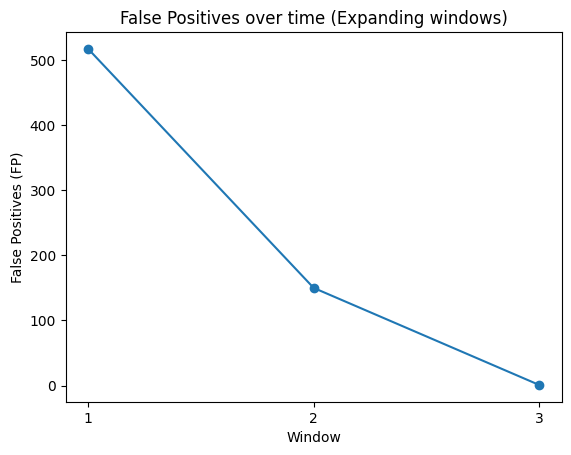

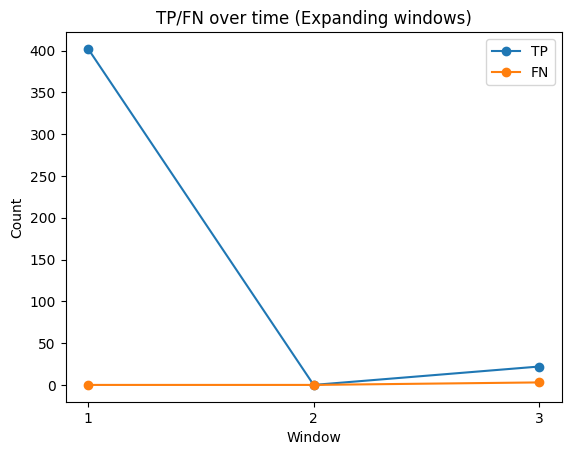

In [186]:
import matplotlib.pyplot as plt

windows = [1, 2, 3]
fp = [517, 150, 1]
fn = [0, 0, 3]
tp = [402, 0, 22]

plt.figure()
plt.plot(windows, fp, marker="o")
plt.xticks(windows)
plt.xlabel("Window")
plt.ylabel("False Positives (FP)")
plt.title("False Positives over time (Expanding windows)")
plt.show()

plt.figure()
plt.plot(windows, tp, marker="o", label="TP")
plt.plot(windows, fn, marker="o", label="FN")
plt.xticks(windows)
plt.xlabel("Window")
plt.ylabel("Count")
plt.title("TP/FN over time (Expanding windows)")
plt.legend()
plt.show()


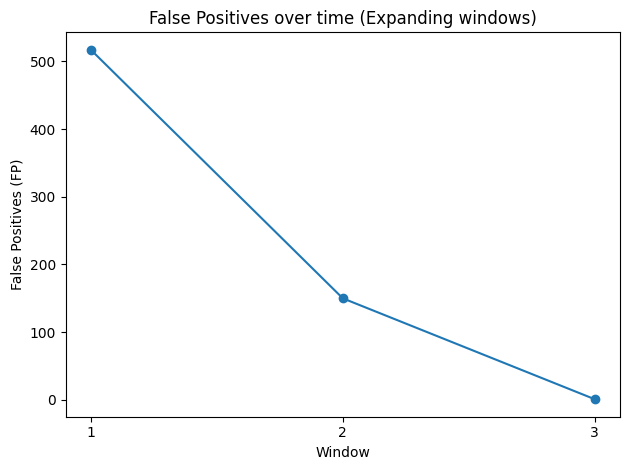

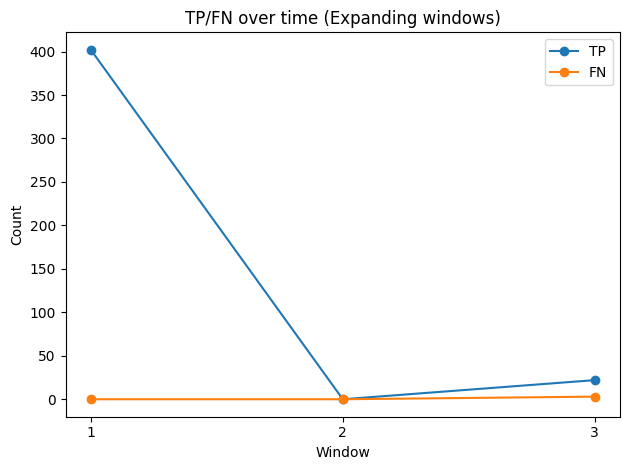

[PosixPath('../assets/tp_fn_over_time.png'),
 PosixPath('../assets/fp_over_time.png')]

In [187]:
assets = Path("../assets")
assets.mkdir(exist_ok=True)

# FP plot
plt.figure()
plt.plot([1,2,3], [517,150,1], marker="o")
plt.xticks([1,2,3])
plt.xlabel("Window")
plt.ylabel("False Positives (FP)")
plt.title("False Positives over time (Expanding windows)")
plt.tight_layout()
plt.savefig(assets / "fp_over_time.png", dpi=200)
plt.show()

# TP/FN plot
plt.figure()
plt.plot([1,2,3], [402,0,22], marker="o", label="TP")
plt.plot([1,2,3], [0,0,3], marker="o", label="FN")
plt.xticks([1,2,3])
plt.xlabel("Window")
plt.ylabel("Count")
plt.title("TP/FN over time (Expanding windows)")
plt.legend()
plt.tight_layout()
plt.savefig(assets / "tp_fn_over_time.png", dpi=200)
plt.show()

list(assets.iterdir())


In [188]:
def read_emails_from_folder(folder_path: Path, label: int, max_files: int | None = None):
    """Read raw email files and return list of dicts with text + label."""
    records = []
    files = sorted([p for p in folder_path.iterdir() if p.is_file()])
    
    if max_files is not None:
        files = files[:max_files]

    for file_path in files:
        "Some emails have weird encoding, so we ignore bad characters"
        text = file_path.read_text(errors="ignore")
        records.append({
            "text": text,
            "label": label,   # 0 = ham, 1 = spam
        })
    return records
            

In [189]:
ham_records = read_emails_from_folder(HAM_DIR, label=0)
spam_records = read_emails_from_folder(SPAM_DIR, label=1)


In [190]:
df = pd.DataFrame(ham_records + spam_records)

In [191]:
print("Total emails:", len(df))
print(df["label"].value_counts())
df.head()

Total emails: 3899
label
0    2501
1    1398
Name: count, dtype: int64


,text,label
0,From exmh-workers-admin@redhat.com Thu Aug 22...,0
1,From Steve_Burt@cursor-system.com Thu Aug 22 ...,0
2,From timc@2ubh.com Thu Aug 22 13:52:59 2002\n...,0
3,From irregulars-admin@tb.tf Thu Aug 22 14:23:...,0
4,From Stewart.Smith@ee.ed.ac.uk Thu Aug 22 14:...,0


In [192]:
from sklearn.model_selection import train_test_split


### Features + labels

In [193]:
X = df["text"]
y = df["label"]

### 1) Train (70%) vs Temp (30%)

In [194]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

### 2) Temp (30%) -> Val (15%) + Test (15%)

In [195]:
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

In [196]:
print("Train size:", len(X_train))
print("Val size:", len(X_val))
print("Test size:", len(X_test))

print("\nTrain label ratio:\n", y_train.value_counts(normalize=True))
print("\nVal label ratio:\n", y_val.value_counts(normalize=True))
print("\nTest label ratio:\n", y_test.value_counts(normalize=True))

Train size: 2729
Val size: 585
Test size: 585

Train label ratio:
 label
0    0.641627
1    0.358373
Name: proportion, dtype: float64

Val label ratio:
 label
0    0.641026
1    0.358974
Name: proportion, dtype: float64

Test label ratio:
 label
0    0.641026
1    0.358974
Name: proportion, dtype: float64


In [197]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression


### Pipeline: vectorizer + model

In [198]:
spam_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        stop_words="english",   # simple baseline
        max_features=50000      # limit size
    )),
    ("model", LogisticRegression(
        max_iter=2000,
        n_jobs=-1
    ))
])


### Train only on train set

In [199]:
spam_pipeline.fit(X_train, y_train)


/Users/ganeshpokharel/projects/email-spam-detection/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


In [200]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


### Predict on validation

In [201]:
y_val_pred = spam_pipeline.predict(X_val)

print("Validation report:\n")
print(classification_report(y_val, y_val_pred, target_names=["ham(0)", "spam(1)"]))


Validation report:

              precision    recall  f1-score   support

      ham(0)       0.99      1.00      1.00       375
     spam(1)       1.00      0.99      1.00       210

    accuracy                           1.00       585
   macro avg       1.00      1.00      1.00       585
weighted avg       1.00      1.00      1.00       585



### Confusion matrix

In [202]:
cm = confusion_matrix(y_val, y_val_pred)


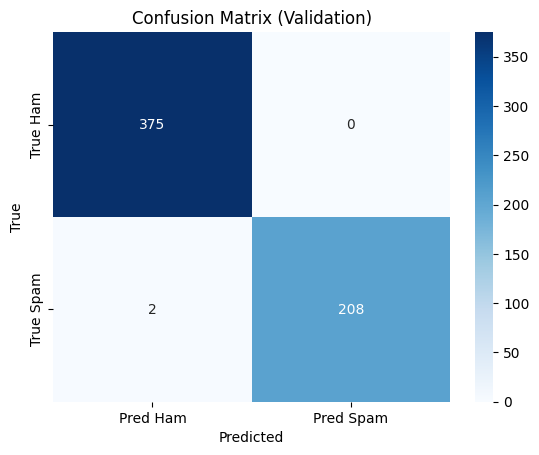

In [203]:
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred Ham", "Pred Spam"],
            yticklabels=["True Ham", "True Spam"])
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Get spam probabilities (class 1 prob)

In [204]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support


In [205]:
val_spam_proba = spam_pipeline.predict_proba(X_val)[:, 1]

In [206]:
def evaluate_threshold(y_true, proba, threshold):
    y_pred = (proba >= threshold).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    return precision, recall, f1

thresholds = [0.3, 0.5, 0.7]

for t in thresholds:
    p, r, f1 = evaluate_threshold(y_val, val_spam_proba, t)
    print(f"Threshold {t:.1f} -> Precision: {p:.3f}, Recall: {r:.3f}, F1: {f1:.3f}")


Threshold 0.3 -> Precision: 0.977, Recall: 0.995, F1: 0.986
Threshold 0.5 -> Precision: 1.000, Recall: 0.990, F1: 0.995
Threshold 0.7 -> Precision: 1.000, Recall: 0.962, F1: 0.981


In [207]:
print("\nExample probs (first 10):")
print(np.round(val_spam_proba[:10], 3))


Example probs (first 10):
[0.015 0.027 0.747 0.97  0.992 0.035 0.86  0.034 0.235 0.021]


### Final Test evaluation (report + confusion matrix)

### 1) probabilities on test

In [208]:
test_spam_proba = spam_pipeline.predict_proba(X_test)[:, 1]

### 2) choose threshold

In [209]:
threshold = 0.5
y_test_pred = (test_spam_proba >= threshold).astype(int)

print(f"TEST report (threshold={threshold}):\n")
print(classification_report(y_test, y_test_pred, target_names=["ham(0)", "spam(1)"]))


TEST report (threshold=0.5):

              precision    recall  f1-score   support

      ham(0)       0.98      1.00      0.99       375
     spam(1)       1.00      0.97      0.98       210

    accuracy                           0.99       585
   macro avg       0.99      0.98      0.99       585
weighted avg       0.99      0.99      0.99       585



### 3) confusion matrix

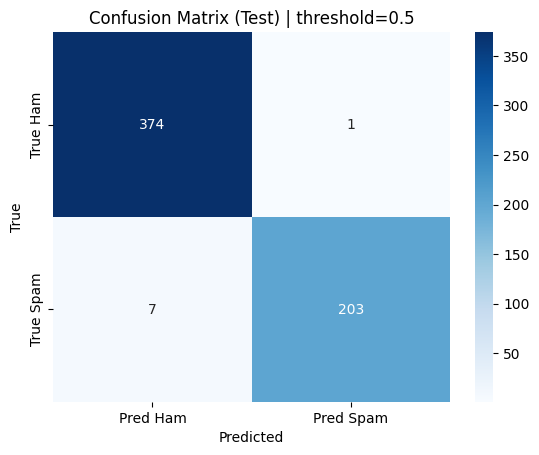

In [210]:
cm_test = confusion_matrix(y_test, y_test_pred)

plt.figure()
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred Ham", "Pred Spam"],
            yticklabels=["True Ham", "True Spam"])
plt.title(f"Confusion Matrix (Test) | threshold={threshold}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [211]:
from pathlib import Path
import joblib


In [212]:
# Save folder
MODELS_DIR = Path("../models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# File paths
pipeline_path = MODELS_DIR / "spam_pipeline.joblib"
threshold_path = MODELS_DIR / "threshold.txt"

# Save pipeline
joblib.dump(spam_pipeline, pipeline_path)

# Save threshold
threshold = 0.5
threshold_path.write_text(str(threshold))

3

In [213]:
print("Saved")
print("Pipeline:", pipeline_path)
print("Threshold:", threshold_path)

Saved
Pipeline: ../models/spam_pipeline.joblib
Threshold: ../models/threshold.txt
